In [2]:
"""
NOTE: This notebook is the first codebase for double encoder-decoder training

gloss weight = 1 
smoothed target 


ua = random.uniform(0.02, 0.06) 
us = random.uniform(4, 8)
ch = random.choice([0, 1, 2])

# scaling the optics value on the basis of the input ground truth reconstruction 
scale = (1+(random_mua/.3)*.01)

if ch ==0: 
    ua_ = ua*random.uniform(1.001,1.02)*scale
    us_ = us*random.uniform(0.98,0.9999)/scale
elif ch == 1: 
    ua_ =  ua*random.uniform(0.98,0.9999)/scale
    us_ = us*random.uniform(1.001,1.02)*scale
else: 
    ua_ = ua*random.uniform(1.001,1.02)*scale 
    us_ =  us*random.uniform(1.001,1.02)*scale 

"""

'\nNOTE: This notebook is the first codebase for double encoder-decoder training\n\ngloss weight = 1 \nsmoothed target \n\n\nua = random.uniform(0.02, 0.06) \nus = random.uniform(4, 8)\nch = random.choice([0, 1, 2])\n\n# scaling the optics value on the basis of the input ground truth reconstruction \nscale = (1+(random_mua/.3)*.01)\n\nif ch ==0: \n    ua_ = ua*random.uniform(1.001,1.02)*scale\n    us_ = us*random.uniform(0.98,0.9999)/scale\nelif ch == 1: \n    ua_ =  ua*random.uniform(0.98,0.9999)/scale\n    us_ = us*random.uniform(1.001,1.02)*scale\nelse: \n    ua_ = ua*random.uniform(1.001,1.02)*scale \n    us_ =  us*random.uniform(1.001,1.02)*scale \n\n'

NOTE: Weighted Loss effectiveness experiment. 

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import tqdm

from Models3 import * ## self defined 
from random_object_generator import Generate_Reconstruction_Image #, Generate_Reconstruction_Image_parallel
from random_mask import get_random_mask_parallel, get_random_mask

In [4]:
DEPTH = np.concatenate([np.load('Data3/Random_Geometry/target_dr.npy'),  np.load('Data3/Random_Geometry/mid/target_dr.npy')], axis = 0) 
DEPTH = DEPTH.reshape(-1, 2)
indr = DEPTH[:, 1]>0.74

In [5]:
# OBJECTS = np.load('Data3/Random_Geometry/objects_random.npy')
# #MASKS = np.load('Data_Random/masks_random.npy')
# OPTICSES = np.load('Data3/Random_Geometry/optics_random.npy')
# MASKS = np.load('Data3/Random_Geometry/masks_not_random.npy')

OBJECTS = np.concatenate([np.load('Data3/Random_Geometry/objects_random.npy'), np.load('Data3/Random_Geometry/mid/objects_random.npy')], axis = 0)[indr]
#MASKS = np.load('Data_Random/masks_random.npy')
OPTICSES = np.concatenate([np.load('Data3/Random_Geometry/optics_random.npy'),  np.load('Data3/Random_Geometry/mid/optics_random.npy')], axis = 0)[indr] 
MASKS = np.concatenate([np.load('Data3/Random_Geometry/masks_not_random.npy'),  np.load('Data3/Random_Geometry/mid/masks_not_random.npy')], axis = 0)[indr]


In [6]:
#OPTICSES = np.concatenate([OPTICSES[:,:2], DEPTH[indr]], axis = 1)
OPTICSES = np.concatenate([OPTICSES[:,:2], OPTICSES[:,:2]], axis = 1)

In [7]:
OPTICSES.shape

(255988, 4)

In [8]:
N_Sample = OPTICSES.shape[0]

In [9]:
def Generate_Reconstruction_Image_Fast(n = N_Sample):
    sample_indxes = np.random.randint(0, n, size=16)
    return OBJECTS[sample_indxes],  MASKS[sample_indxes], OPTICSES[sample_indxes]

## MODEL Definations

In [10]:
# forward_model = Forward_Operator() 
# x = forward_model(torch.randn(2,7, 32,32), torch.randn(2, 4)) #, torch.tensor([10,5])).shape
# print(x.shape)

In [11]:
# inverse_model = Inverse_Operator() 
# pert = inverse_model(torch.randn(2,7, 32,32), torch.randn(2, 18, 14), torch.randn(2,4))#, torch.tensor([10,5])).shape
# print(pert.shape)

In [12]:
# dis = Discriminator()
# x = dis(torch.randn(16, 7, 32, 32), torch.randn(16, 18, 14), torch.randn(16, 4))
# print(x.shape)

# Load the dataset 

In [13]:
import numpy as np 

X10 = np.load("Data3/all_rad_mua8/All_measured_data_phan.npy")
y10 = np.load("Data3/all_rad_mua8/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask10 = np.load("Data3/all_rad_mua8/All_fine_meshes_phan.npy")
optics10 = np.load("Data3/all_rad_mua8/All_background_optics_phan.npy")
target10 = np.load("Data3/all_rad_mua8/Target_depth_radius_phan.npy")


X11 = np.load("Data3/rad.75/All_measured_data_phan.npy")
y11 = np.load("Data3/rad.75/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask11 = np.load("Data3/rad.75/All_fine_meshes_phan.npy")
optics11 = np.load("Data3/rad.75/All_background_optics_phan.npy")
target11 = np.load("Data3/rad.75/Target_depth_radius_phan.npy")

X12 = np.load("Data3/rad.9/All_measured_data_phan.npy")
y12 = np.load("Data3/rad.9/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask12 = np.load("Data3/rad.9/All_fine_meshes_phan.npy")
optics12 = np.load("Data3/rad.9/All_background_optics_phan.npy")
target12 = np.load("Data3/rad.9/Target_depth_radius_phan.npy")

X13 = np.load("Data3/rad1.05/All_measured_data_phan.npy")
y13 = np.load("Data3/rad1.05/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask13 = np.load("Data3/rad1.05/All_fine_meshes_phan.npy")
optics13 = np.load("Data3/rad1.05/All_background_optics_phan.npy")
target13 = np.load("Data3/rad1.05/Target_depth_radius_phan.npy")

X14 = np.load("Data3/rad1.2/All_measured_data_phan.npy")
y14 = np.load("Data3/rad1.2/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask14 = np.load("Data3/rad1.2/All_fine_meshes_phan.npy")
optics14 = np.load("Data3/rad1.2/All_background_optics_phan.npy")
target14 = np.load("Data3/rad1.2/Target_depth_radius_phan.npy")


X15 = np.load("Data3/depth3.5/All_measured_data_phan.npy")
y15 = np.load("Data3/depth3.5/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask15 = np.load("Data3/depth3.5/All_fine_meshes_phan.npy")
optics15 = np.load("Data3/depth3.5/All_background_optics_phan.npy")
target15 = np.load("Data3/depth3.5/Target_depth_radius_phan.npy")


X16 = np.load("Data3/depthmrad.75/All_measured_data_phan.npy")
y16 = np.load("Data3/depthmrad.75/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask16 = np.load("Data3/depthmrad.75/All_fine_meshes_phan.npy")
optics16 = np.load("Data3/depthmrad.75/All_background_optics_phan.npy")
target16 = np.load("Data3/depthmrad.75/Target_depth_radius_phan.npy")

X17 = np.load("Data3/depthmrad.9/All_measured_data_phan.npy")
y17 = np.load("Data3/depthmrad.9/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask17 = np.load("Data3/depthmrad.9/All_fine_meshes_phan.npy")
optics17 = np.load("Data3/depthmrad.9/All_background_optics_phan.npy")
target17 = np.load("Data3/depthmrad.9/Target_depth_radius_phan.npy")

X18 = np.load("Data3/depthmrad1.05/All_measured_data_phan.npy")
y18 = np.load("Data3/depthmrad1.05/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask18 = np.load("Data3/depthmrad1.05/All_fine_meshes_phan.npy")
optics18 = np.load("Data3/depthmrad1.05/All_background_optics_phan.npy")
target18 = np.load("Data3/depthmrad1.05/Target_depth_radius_phan.npy")

X19 = np.load("Data3/depthmrad1.2/All_measured_data_phan.npy")
y19 = np.load("Data3/depthmrad1.2/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask19 = np.load("Data3/depthmrad1.2/All_fine_meshes_phan.npy")
optics19 = np.load("Data3/depthmrad1.2/All_background_optics_phan.npy")
target19 = np.load("Data3/depthmrad1.2/Target_depth_radius_phan.npy")


X20 = np.load("Data3/depthmrad.5/All_measured_data_phan.npy")
y20 = np.load("Data3/depthmrad.5/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask20 = np.load("Data3/depthmrad.5/All_fine_meshes_phan.npy")
optics20 = np.load("Data3/depthmrad.5/All_background_optics_phan.npy")
target20 = np.load("Data3/depthmrad.5/Target_depth_radius_phan.npy")


X21 = np.load("Data3/rad.5/All_measured_data_phan.npy")
y21 = np.load("Data3/rad.5/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
mask21 = np.load("Data3/rad.5/All_fine_meshes_phan.npy")
optics21 = np.load("Data3/rad.5/All_background_optics_phan.npy")
target21 = np.load("Data3/rad.5/Target_depth_radius_phan.npy")



In [14]:
X = np.concatenate([ X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21], axis = 0)
y = np.concatenate([ y10, y11, y12, y13, y14, y15, y16, y17, y18, y19, y20, y21], axis = 0)
Mask = np.concatenate([ mask10, mask11,  mask12,  mask13,  mask14, mask15, mask16, mask17, mask18, mask19, mask20, mask21], axis = 0)
optics = np.concatenate([ optics10, optics11,  optics12,  optics13,  optics14, optics15, optics16, optics17, optics18, optics19, optics20, optics21], axis = 0)
target = np.concatenate([ target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20, target21], axis = 0)

In [15]:
# X = np.concatenate([ X20, X21], axis = 0)
# y = np.concatenate([  y20, y21], axis = 0)
# Mask = np.concatenate([  mask20, mask21], axis = 0)
# optics = np.concatenate([  optics20, optics21], axis = 0)
# target = np.concatenate([  target20, target21], axis = 0)

In [16]:
print(X.shape)
print(y.shape) 
print(Mask.shape) #= X[:,:36, :]
print(optics.shape)
print(target.shape)

(23530, 18, 14)
(23530, 7, 32, 32)
(23530, 7, 32, 32)
(23530, 4)
(23530, 2)


In [17]:
optics = np.concatenate([optics[:,:2], optics[:,:2]], axis = 1)

In [18]:
from sklearn.model_selection import train_test_split
test_size = 0.1
random_state = 42
X_train,  X_test, Mask_train,  Mask_test, optics_train, optics_test, tar_train, tar_test,  y_train, y_test = train_test_split(X, Mask, optics, target, y, test_size=test_size, random_state=random_state)

In [19]:
from scipy.ndimage import convolve

# Define the filter kernel
filter_size = 7 #np.random.choice(filter_sizes)
filter_kernel = np.ones((1, filter_size, filter_size))
filter_kernel  /= np.sum(filter_kernel)

filter_size2 = 3 #np.random.choice(filter_sizes)
filter_kernel2 = np.ones((1, filter_size2, filter_size2))
#filter_kernel2 /= np.sum(filter_kernel2)

#space_with_object_avg = convolve(space_with_object, filter_kernel, mode='nearest')


In [20]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset 
import numpy as np
import torch

           
class myDataset(Dataset): 
    def __init__(self, train = True): 
        self.X_train = X_train# .reshape(-1, 18, 14) 
        self.Mask_train = Mask_train 
        self.Mask_test = Mask_test 
        self.y_train = y_train# .transpose((0, 3,1,2)) 
        self.X_test = X_test #.reshape(-1, 18, 14)
        self.y_test = y_test #.transpose((0, 3,1,2)) 
        self.train = train

        self.optics_train = optics_train 
        self.optics_test = optics_test 

        self.tar_train = tar_train
        self.tar_test = tar_test 

    def __len__(self):
        if self.train: 
            return len(self.X_train) 
        else: 
            return len(self.X_test) 
    def __getitem__(self, idx):
        if self.train:
            temp = self.y_train[idx] 
            #temp2 = y_train.max(axis = (1, 2), keepdims = True)
            if self.tar_train[idx][1] > 0.4:
                y_train_  = convolve(temp, filter_kernel, mode='nearest')
                y_train_ = y_train_ + temp
                y_train_ = convolve(y_train_, filter_kernel2, mode='nearest')
                y_train_  = (y_train_ /(1e-7+y_train_.max(axis = (1, 2), keepdims = True)))* temp.max(axis = (1, 2), keepdims = True)

                return torch.Tensor(self.X_train[idx]),torch.Tensor(self.Mask_train[idx]), torch.Tensor(self.optics_train[idx]), self.tar_train[idx],  torch.Tensor(y_train_)
            else: 
                return torch.Tensor(self.X_train[idx]),torch.Tensor(self.Mask_train[idx]), torch.Tensor(self.optics_train[idx]), self.tar_train[idx],  torch.Tensor(y_train[idx])

        else: 
            temp = self.y_test[idx] 
            #temp2 = y_train.max(axis = (1, 2), keepdims = True)
            if self.tar_test[idx][1] > 0.4:
                y_test_  = convolve(temp, filter_kernel, mode='nearest')
                y_test_ = y_test_ + temp 
                y_test_ = convolve(y_test_, filter_kernel2, mode='nearest')

                y_test_  = (y_test_ /(1e-7+y_test_.max(axis = (1, 2), keepdims = True)))* temp.max(axis = (1, 2), keepdims = True)

                return torch.Tensor(self.X_test[idx]),torch.Tensor(self.Mask_test[idx]), torch.Tensor(self.optics_test[idx]), self.tar_test[idx],  torch.Tensor(y_test_)
            else: 
                #return torch.Tensor(self.X_test[idx]),torch.Tensor(self.Mask_test[idx]), torch.Tensor(self.optics_test[idx]), self.tar_test[idx],  torch.Tensor(y_test[idx])
                return torch.Tensor(self.X_test[idx]),torch.Tensor(self.Mask_test[idx]), torch.Tensor(self.optics_test[idx]), self.tar_test[idx], torch.Tensor(self.y_test[idx])
      

BATCH_SIZE = 16     
device  = "cuda" if torch.cuda.is_available() else "cpu"

train_dataset = myDataset() 
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataset = myDataset(train= False) 
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

In [21]:
X_phan = np.load("phan/All_measured_data_phan.npy")
y_phan = np.load("phan/All_ground_truth_phan.npy") #.transpose((0, 3,1,2))
Mask_phan = np.load("phan/All_fine_meshes_phan.npy")
optics_phan = np.load("phan/All_background_optics_phan.npy")
target_phan = np.load("phan/Target_depth_radius_phan.npy")

optics_phan = np.concatenate([optics_phan[:,:2], optics_phan[:,:2]], axis = 1)


class myDataset_phan(Dataset): 
    def __init__(self, train = True): 
        self.X_train = X_phan# .reshape(-1, 18, 14) 
        self.Mask_train = Mask_phan 
        self.y_train = y_phan# .transpose((0, 3,1,2)) 
        self.train = train

        self.optics_train = optics_phan
        self.tar_train = target_phan

    def __len__(self):
        if self.train: 
            return len(self.X_train) 
    def __getitem__(self, idx):
        if self.train:
            temp = self.y_train[idx] 
            if self.tar_train[idx][1] > 0.4:
                y_train_  = convolve(temp, filter_kernel, mode='nearest')
                y_train_ = y_train_ + temp
                y_train_ = convolve(y_train_, filter_kernel2, mode='nearest')
                y_train_  = (y_train_ /(1e-7+y_train_.max(axis = (1, 2), keepdims = True)))* temp.max(axis = (1, 2), keepdims = True)

                return torch.Tensor(self.X_train[idx]),torch.Tensor(self.Mask_train[idx]), torch.Tensor(self.optics_train[idx]), self.tar_train[idx],  torch.Tensor(y_train_)
            else: 
                return torch.Tensor(self.X_train[idx]),torch.Tensor(self.Mask_train[idx]), torch.Tensor(self.optics_train[idx]), self.tar_train[idx],  torch.Tensor(y_train[idx])
            
test_phan_dataset = myDataset_phan() 
phan_dataloader = DataLoader(test_phan_dataset, batch_size = 1, shuffle = False, drop_last = False)


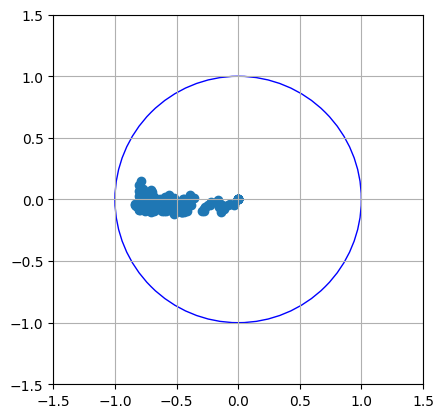

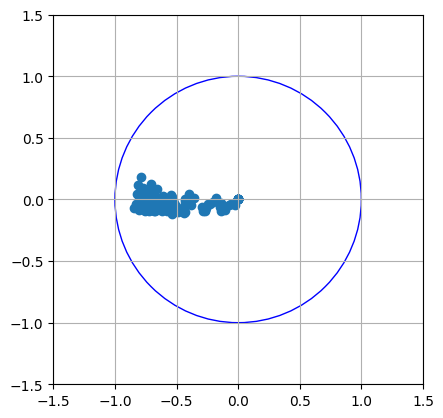

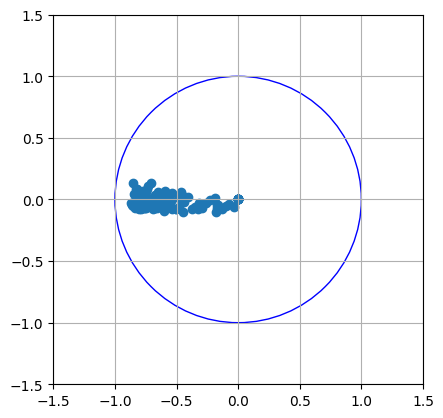

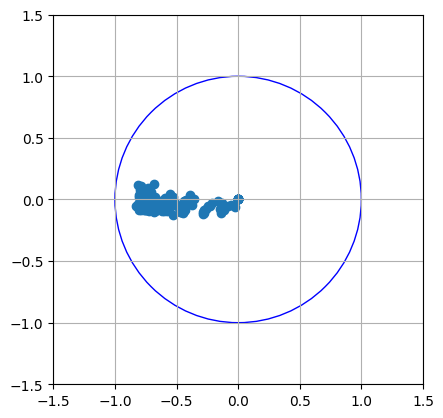

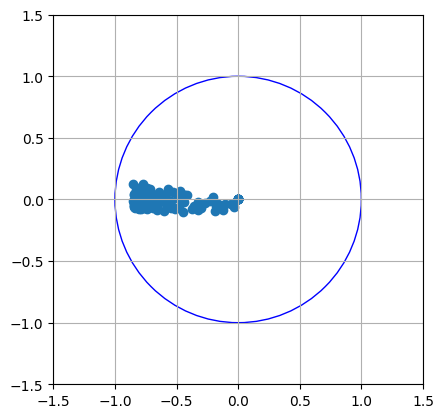

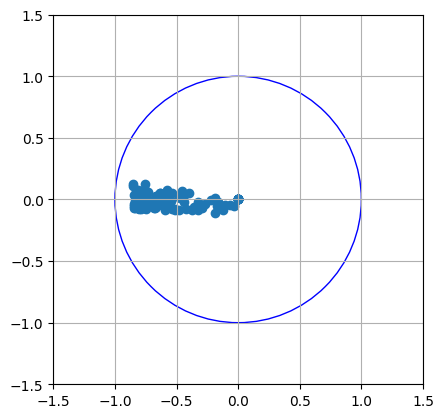

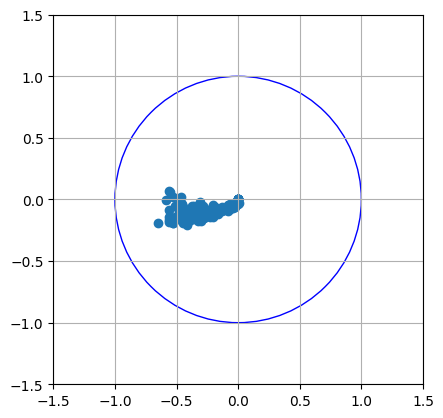

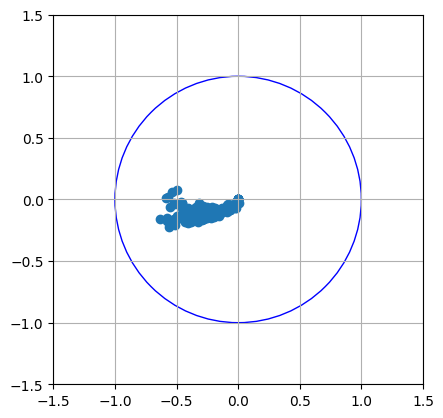

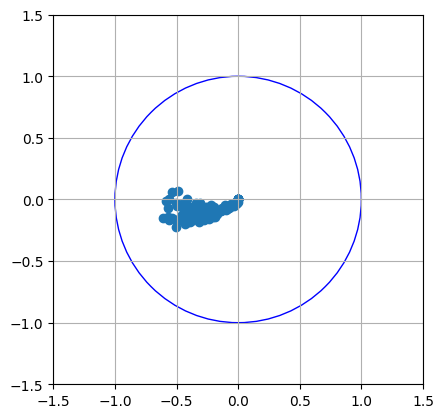

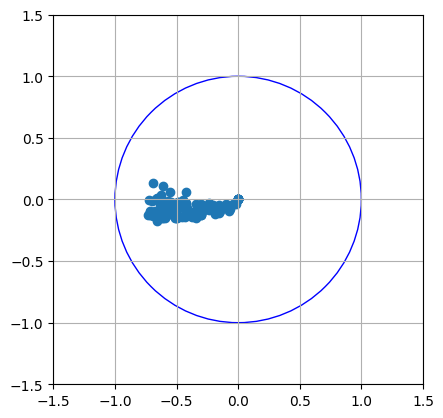

In [22]:
for i in range(10):
    #plt.

    
    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Create and add the circle to the axis
    circle = plt.Circle((0, 0), 1, edgecolor='b', facecolor='none')
    ax.add_patch(circle)

    # # Plot the scatter data
    # for data in All_measured_data:
    #     ax.scatter(data[0], data[1])
    #pred_per = pred_pert[0].detach().cpu().numpy()

    # #for i in range(0,1):
    ax.scatter(X_phan[i, :9,:], X_phan[i,9:,:])
    # print("Mua target", All_ground_truth[i].max()) 
    #print("Optics:", optics_gen[0].detach().cpu().numpy())
    # print("Depth, Radius", Target_depth_radius[i])

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set limits to ensure the circle is centered and visible
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    # Add grid for better visualization
    ax.grid(True)

    # Display the plot
    plt.show()

    plt.show()

## Visualization

In [23]:
sample = next(iter(phan_dataloader))
mask = sample[1]
image = sample[4]

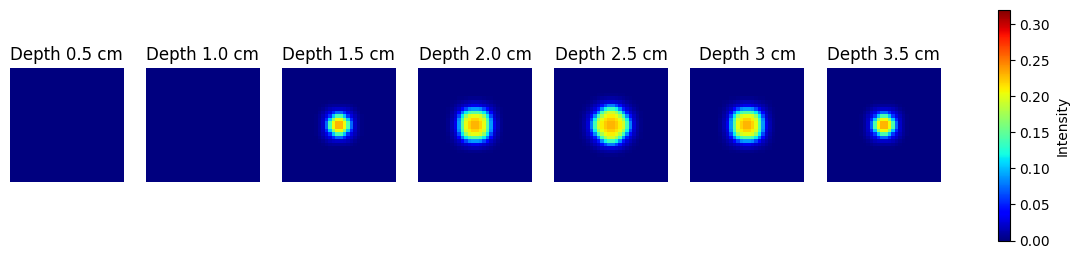

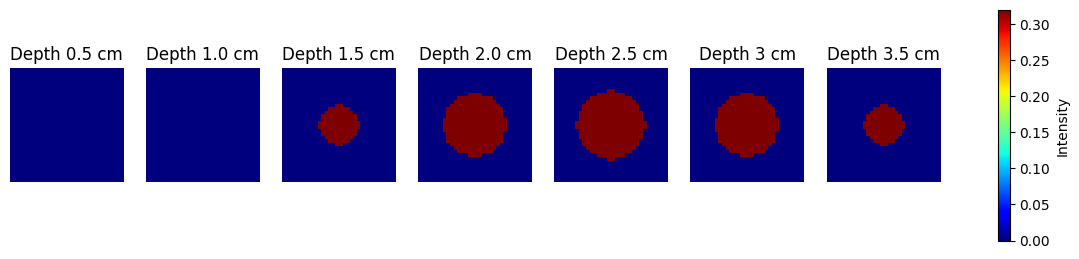

In [24]:
sample = next(iter(phan_dataloader))
mask = sample[1]
image = sample[4]

depth = [0.5, 1.0, 1.5, 2.0, 2.5, 3, 3.5]
def show_tensor_image2(img):
    img = img.detach().to('cpu').numpy()
    num_slices = 7
    slice_positions = np.linspace(0, 6, num_slices, dtype=int)
    
    # Create subplots
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))

    # Plot slices
    for i, pos in enumerate(slice_positions):
        if img.shape[0]>1:
            temp = img.squeeze()[0, i, :,:].squeeze()
        else: 
            temp = img.squeeze()[i, :,:].squeeze()
        
        slice_data = temp
        im = axes[i].imshow(slice_data,vmin = 0, vmax = 0.32, cmap='jet')
        axes[i].set_title(f"Depth {depth[pos]} cm")
        axes[i].axis('off')
        
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label('Intensity')
    plt.show()
    

show_tensor_image2(image)
show_tensor_image2(mask)

In [1]:
def sample_plot_image_all(model):
    for step, (batchmeasured, batch_mask,b_opt, b_tar, batch_actual_image) in enumerate(test_dataloader):
        batchmeasured = batchmeasured.to(device) #.view(-1, 18, 14) 
        batch_actual_image = batch_actual_image.to(device) #.view(-1, 7, 32, 32) 
        batch_mask = batch_mask.to(device)
        b_opt = b_opt.to(device)
        pred_reconstruction = model(batch_mask, batchmeasured, b_opt)

        mask_ran = get_random_mask(b_tar.numpy(), batch_actual_image.cpu().numpy())
        mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)
        #mask_ran = mask_ran* mask.max(dim = (2, 3))

        show_tensor_image2(batch_actual_image)
        show_tensor_image2(mask_ran)
        show_tensor_image2(pred_reconstruction.detach())

def sample_plot_image(model):
    for step, (batchmeasured, batch_mask, b_opt, b_tar, batch_actual_image) in enumerate(test_dataloader):
        batchmeasured = batchmeasured.to(device) #.view(-1, 18, 14) 
        batch_actual_image = batch_actual_image.to(device) #.view(-1, 7, 32, 32) 
        batch_mask = batch_mask.to(device)
        b_opt = b_opt.to(device)
        pred_reconstruction = model(batch_mask, batchmeasured, b_opt)
        mask_ran = get_random_mask(b_tar.numpy(), batch_actual_image.cpu().numpy())
        
        mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)
        #mask_ran = mask_ran* mask.max(dim = (2, 3))
        
        show_tensor_image2(batch_actual_image)
        show_tensor_image2(mask_ran)
        show_tensor_image2(pred_reconstruction.detach())
        break 
        

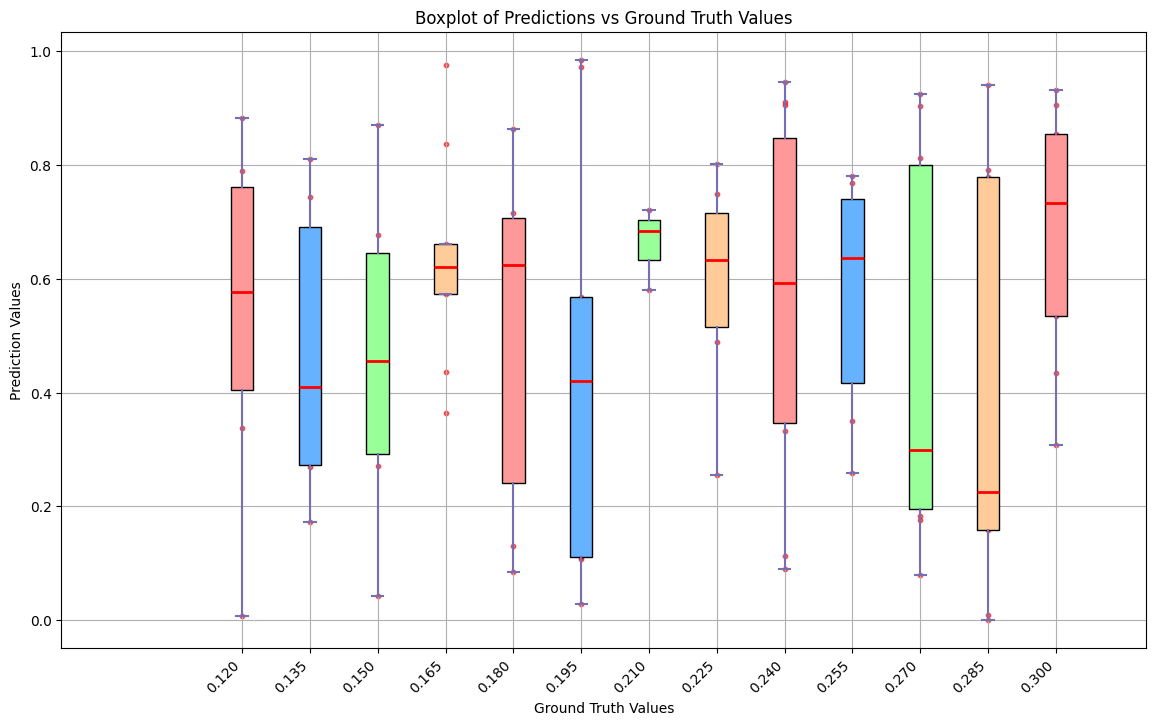

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def error_plot(predictions, corresponding_ground_truth):
    predictions = np.array(predictions)
    corresponding_ground_truth = np.round(np.array(corresponding_ground_truth), 3)  # Round to 3 decimal places
    #ground_truth = np.round(np.arange(0.12, 0.31, 0.015), 3)  # Round to 3 decimal places
    ground_truth = np.sort(np.unique(corresponding_ground_truth))

    data_dict = {value: [] for value in ground_truth}

    for gt_value in ground_truth:
        cond1 = corresponding_ground_truth > (gt_value - 0.001)
        cond2 = corresponding_ground_truth < (gt_value + 0.001)
        cond = cond1 & cond2
        pred_for_value = predictions[cond]
        if len(pred_for_value) > 0:
            data_dict[gt_value].extend(pred_for_value)
    
    # Prepare data for boxplot
    boxplot_data = [data_dict[gt_value] for gt_value in ground_truth if len(data_dict[gt_value]) > 0]
    filtered_ground_truth = [gt_value for gt_value in ground_truth if len(data_dict[gt_value]) > 0]
    
    # Plotting the data
    plt.figure(figsize=(14, 8))

    box = plt.boxplot(boxplot_data, positions=filtered_ground_truth, widths=0.005, patch_artist=True, showfliers=False)
    
    # Customize boxplot colors
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
    for patch, color in zip(box['boxes'], colors*int(np.ceil(len(box['boxes'])/len(colors)))):
        patch.set_facecolor(color)
    
    # Customize other boxplot elements
    for whisker in box['whiskers']:
        whisker.set(color='#7570b3', linewidth=1.5)
    
    for cap in box['caps']:
        cap.set(color='#7570b3', linewidth=1.5)
    
    for median in box['medians']:
        median.set(color='red', linewidth=2)
    
    for flier in box['fliers']:
        flier.set(marker='o', color='#e7298a', alpha=0.5)
    
    #plt.scatter(corresponding_ground_truth, predictions, color='r', alpha=0.6, s=10)
    plt.scatter(corresponding_ground_truth, predictions, color='r', alpha=0.6, s=10)


    # Adding labels and title
    plt.xlabel('Ground Truth Values')
    plt.ylabel('Prediction Values')
    plt.title('Boxplot of Predictions vs Ground Truth Values')
    plt.grid(True)

    # Set x-axis limits
    plt.xlim(0.08, 0.32)

    # Rotate x-axis labels and format them
    plt.xticks(rotation=45, ha='right')

    # Set x-axis ticks and labels
    plt.gca().set_xticks(filtered_ground_truth)
    plt.gca().set_xticklabels([f'{val:.3f}' for val in filtered_ground_truth])

    # Show the plot
    plt.show()

# Example data
ground_truth = np.arange(0.12, 0.31, 0.015)
predictions = np.random.random(100)  # Example predictions
corresponding_ground_truth = np.random.choice(ground_truth, 100)  # Example corresponding ground truth values

error_plot(predictions, corresponding_ground_truth)

In [3]:
from sklearn.metrics import r2_score

def mse_error(x, x_head, mask):
    # Compute the maximum value over the last two dimensions sequentially
    x_max = x.max(dim=-1, keepdim=False)[0].max(dim=-1, keepdim=False)[0]
    x_head = x_head*mask 
    x_head_max = x_head.max(dim=-1, keepdim=False)[0].max(dim=-1, keepdim=False)[0]

    x_max_all7 = x.max()
    x_head_max_all7 = x_head.max()

    return F.mse_loss(x_max, x_head_max), x_max_all7.item(), x_head_max_all7.item()

In [4]:
def scatter_plot_pert(pred_pert, optics_gen):
    # plt.scatter(All_measured_data[i][:9], All_measured_data[i][9:])
    # plt.show()

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Create and add the circle to the axis
    circle = plt.Circle((0, 0), 1, edgecolor='b', facecolor='none')
    ax.add_patch(circle)

    # # Plot the scatter data
    # for data in All_measured_data:
    #     ax.scatter(data[0], data[1])
    pred_per = pred_pert[0].detach().cpu().numpy()

    # #for i in range(0,1):
    ax.scatter(pred_per[:9],pred_per[9:] )
    # print("Mua target", All_ground_truth[i].max()) 
    print("Optics:", optics_gen[0].detach().cpu().numpy())
    # print("Depth, Radius", Target_depth_radius[i])

    # Set the aspect of the plot to be equal
    ax.set_aspect('equal')

    # Set limits to ensure the circle is centered and visible
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)

    # Add grid for better visualization
    ax.grid(True)

    # Display the plot
    plt.show()
    #break

# Training

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
inverse_model = Inverse_Operator().to(device)
inverse_model.load_state_dict(torch.load('checkpoints/model_weights_inverse_operator_best.pth')) 
forward_model = Forward_Operator().to(device)
forward_model.load_state_dict(torch.load('checkpoints/model_weights_forward_operator_best.pth')) 
dis = Discriminator(input_shape=7520).to(device)
dis.load_state_dict(torch.load('checkpoints/model_weights_discriminator_best.pth')) 

NameError: name 'torch' is not defined

In [29]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# inverse_model = Inverse_Operator().to(device)
# forward_model = Forward_Operator().to(device)
# dis = Discriminator().to(device)
opt_inverse = optim.Adam(inverse_model.parameters(), lr = 0.00002, betas = (0.5, 0.999))
opt_forward = optim.Adam(forward_model.parameters(), lr = 0.00002, betas = (0.5, 0.999))
opt_dis = optim.Adam(dis.parameters(), lr = 0.00002, betas = (0.5, 0.999))

In [30]:
mask[mask<1].shape

torch.Size([6196])

### Loss functions 

In [31]:
import torch
import torch.nn.functional as F

def Weighted_Loss(x, x_head, mask):
    # Compute the maximum value over the last two dimensions sequentially
    x_max = x.max(dim=-1, keepdim=True)[0].max(dim=-2, keepdim=True)[0]
    
    # Normalize the input tensors by the maximum value
    x_normalized = x / (x_max + 1e-6) * mask 
    x_head_normalized = x_head / (x_max + 1e-6)* mask 

    mask_ind = mask<0.01

    # Compute and return the L1 loss
    return F.l1_loss(x, x_head) + F.l1_loss(x_normalized, x_head_normalized)   + F.l1_loss(x_head[mask_ind],mask[mask_ind])

# Example usage
loss = Weighted_Loss(torch.randn(2, 7, 32, 32), torch.randn(2, 7, 32, 32), torch.randn(2, 7, 32, 32))
print(loss)


bce = nn.BCEWithLogitsLoss()

tensor(2.5546)


In [32]:
def test_fn2(inverse_model, loader, epoch=0): 
    #inverse_model.eval()
    pbart = tqdm.tqdm(loader, leave = True)
    mselosses = 0 
    gt_max = []
    pred_max = []

    for idx,(pert_label, mask, b_optics, b_tar, Mua_Ground_Truth) in enumerate(pbart):
        pert_label = pert_label.to(device) # input tabular type 
        mask = mask.to(device) # target  image type 
        b_optics = b_optics.to(device) 
        Mua_Ground_Truth = Mua_Ground_Truth.to(device)

        #mask_ran = get_random_mask(b_tar.numpy(), Mua_Ground_Truth.cpu().numpy())
        #mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)
        mask_ran = mask 

        ## train perturbation 2 perturbation model 
        ##########################################
        Mua_Recons = inverse_model(mask_ran, pert_label, b_optics)
        mse, gt, pred = mse_error(Mua_Ground_Truth, Mua_Recons, mask_ran)

        gt_max.append(gt)
        pred_max.append(pred)

        mselosses += mse.item()

        if idx % 10 == 0:
            pbart.set_postfix(
                Mean_Square_Error = mse.item(), 
            )
    #inverse_model.train()
    # plt.scatter(gt_max, pred_max)
    # plt.show()

    if epoch%3 ==0: 
        error_plot(pred_max, gt_max)
        
    return mselosses/len(pbart) , r2_score(gt_max, pred_max)

In [33]:
def test_fn(inverse_model, forward_model, dis, loader, opt_inverse, opt_forward, opt_dis, epoch, save_data = False):
    #inverse_model.eval()
    pbart = tqdm.tqdm(loader, leave = True)
    mselosses = 0 
    gt_max = []
    pred_max = []

    for idx,(pert_label, mask, b_optics, b_tar, Mua_Ground_Truth) in enumerate(pbart):
        pert_label = pert_label.to(device) # input tabular type 
        mask = mask.to(device) # target  image type 
        b_optics = b_optics.to(device)
        Mua_Ground_Truth = Mua_Ground_Truth.to(device)

        #mask_ran = get_random_mask(b_tar.numpy(), Mua_Ground_Truth.cpu().numpy())
        #mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)
        mask_ran = mask 

        ## train perturbation 2 perturbation model 
        ##########################################
        Mua_Recons = inverse_model(mask, pert_label, b_optics)
        mse, gt, pred = mse_error(Mua_Ground_Truth, Mua_Recons, mask_ran)

        gt_max.append(gt)
        pred_max.append(pred)

        mselosses += mse.item()

        if idx % 10 == 0:
            pbart.set_postfix(
                Mean_Square_Error = mse.item(), 
            )
    #inverse_model.train()
    # plt.scatter(gt_max, pred_max)
    # plt.show()
    if save_data: 
        gt_max = np.array(gt_max)
        pred_max = np.array(pred_max)
        
        # Save the arrays to .npy files
        np.save("checkpoints_all_less/gt_max.npy", gt_max)
        np.save("checkpoints_all_less/pred_max.npy", pred_max)

    if epoch%3 ==0: 
        error_plot(pred_max, gt_max)
        
    return mselosses/len(pbart) , r2_score(gt_max, pred_max)

In [34]:
def train_fn(inverse_model, forward_model, dis, loader, opt_inverse, opt_forward, opt_dis, epoch):
    pbar = tqdm.tqdm(loader, leave = True)
    #print(len(pbar))
    #for idx,(batchmeasured, batch_mask, batch_actual_image) in enumerate(pbar):
    for idx,(pert_label, mask, b_optics, b_tar, Mua_Ground_Truth) in enumerate(pbar):
        pert_label = pert_label.to(device) # input tabular type 
        mask = mask.to(device) # target  image type 
        mask_ran = mask 
        #mask = mask.max(axis = 1)
        b_optics = b_optics.to(device)
        Mua_Ground_Truth = Mua_Ground_Truth.to(device)

        #mask_ran = get_random_mask(b_tar.numpy(), Mua_Ground_Truth.cpu().numpy())
        #mask_ran = torch.tensor(mask_ran, dtype = torch.float32, device = device)


        ## train perturbation 2 perturbation model 
        ##########################################
        Mua_Recons = inverse_model(mask_ran, pert_label, b_optics)
        pert_pred = forward_model(Mua_Recons, b_optics)
        loss_pert = F.l1_loss(pert_label[:,:18,:], pert_pred)
        loss_recons1 = Weighted_Loss(Mua_Ground_Truth*mask_ran, Mua_Recons, mask_ran)*1.5 #* 0.1
        #loss_recons2 = loss_pert # F.mse_loss(Mua_Ground_Truth.view(BATCH_SIZE, 7, -1).max(dim = -1)[0], Mua_Recons.view(BATCH_SIZE, 7, -1).max(dim = -1)[0])*0.1
        loss_recons = loss_recons1 + loss_pert #loss_recons2

        

        ### trian the discriminator 
        #pert_pred = forward_model(Mua_Recons, b_optics)
        D_real = dis(mask_ran, pert_label, torch.cat([b_optics[:,:2].repeat([1,20]), Mua_Ground_Truth.amax(dim = [1,2,3]).unsqueeze(1).repeat([1,60])], axis =1))
        D_real_loss = bce(D_real, torch.ones_like(D_real))
        D_fake = dis(mask_ran, pert_pred.detach(), torch.cat([b_optics[:,:2].repeat([1,20]), Mua_Ground_Truth.amax(dim = [1,2,3]).unsqueeze(1).repeat([1,60])], axis =1))
        D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))

        # # Weight update for the discriminator 
        # D_loss = (D_fake_loss + D_real_loss)/2 
        # opt_dis.zero_grad()
        # D_loss.backward() #retain_graph = True)
        # opt_dis.step()
        # #continue


        # Weight update for the inverse operator 
        opt_inverse.zero_grad()
        opt_forward.zero_grad()
        loss_recons.backward()
        opt_inverse.step()
        opt_forward.step()


        # # Weight update for the inverse operator 
        # opt_inverse.zero_grad()
        # loss_recons.backward()
        # opt_inverse.step()



        # # weigth update for the forward operator 
        # opt_forward.zero_grad()
        # loss_pert.backward()
        # opt_forward.step()

        


        ## train reconstruction 2 reconstruction model 
        ##########################################
        Mua_GT_generated, mask_gen, optics_gen = Generate_Reconstruction_Image_Fast()
        Mua_GT_generated = torch.tensor(Mua_GT_generated, dtype = torch.float32, device = device) 
        mask_gen = torch.tensor(mask_gen, dtype = torch.float32, device = device)
        optics_gen = torch.tensor(optics_gen, dtype = torch.float32, device = device)
        pert_pred2 = forward_model(Mua_GT_generated, optics_gen)

        ### trian the discriminator 
        


        D_fake2 = dis(mask_gen, pert_pred2.detach(), torch.cat([optics_gen[:,:2].repeat([1,20]), Mua_GT_generated.amax(dim = [1,2,3]).unsqueeze(1).repeat([1,60])], axis =1))
        D_fake_loss2 = bce(D_fake2, torch.zeros_like(D_fake))

        # Weight update for the discriminator 
        D_loss = (D_fake_loss*0.2 + D_real_loss + D_fake_loss2)/3
        opt_dis.zero_grad()
        D_loss.backward() #retain_graph = True)
        opt_dis.step()
        #continue
        
        
        
        Mua_Recons = inverse_model(mask_gen, pert_pred2, optics_gen)
        D_fake3 = dis(mask_gen, pert_pred2 , torch.cat([optics_gen[:,:2].repeat(1,20), Mua_GT_generated.amax(dim = [1,2,3]).unsqueeze(1).repeat([1,60])], axis =1))
        G_fake_loss = bce(D_fake3, torch.ones_like(D_fake))
        
        loss_recons3 = Weighted_Loss(Mua_GT_generated*mask_gen, Mua_Recons, mask_gen)*1.5 #*0.1
        #loss_recons4 = 0 #F.mse_loss(Mua_GT_generated.view(BATCH_SIZE, 7, -1).max(dim = -1)[0], Mua_Recons.view(BATCH_SIZE, 7, -1).max(dim = -1)[0])*0.1

        loss_recons5 = loss_recons3 +  G_fake_loss*0.001
        # if epoch>10: 
        #     loss_recons5 = loss_recons3 +  G_fake_loss*0.001 #+ (loss_recons1 + loss_pert)
        # else: 
        #     loss_recons5 = loss_recons3




        # Weight update for the inverse operator 
        opt_inverse.zero_grad()
        opt_forward.zero_grad()
        loss_recons5.backward()
        opt_inverse.step()
        #G_fake_loss.backward()
        #weights_before = {name: param.clone() for name, param in forward_model.named_parameters()}
        opt_forward.step()
        # weights_after = {name: param for name, param in forward_model.named_parameters()}

        # for name in weights_before:
        #     if torch.equal(weights_before[name], weights_after[name]):
        #         print(f"Weights for {name} have not changed.")
        #     else:
        #         print(f"Weights for {name} have changed.")

        # pert_pred = forward_model(Mua_GT_generated, optics_gen)
        # D_fake = dis(Mua_GT_generated, pert_pred.detach(), optics_gen)
        # G_fake_loss = bce(D_fake, torch.ones_like(D_fake))*1e-2
        # opt_forward.zero_grad()
        # G_fake_loss.backward()
        # opt_forward.step()


        


        if epoch % 3 == 0 and idx == 0:
            print("r2r")
            show_tensor_image2(Mua_GT_generated)
            show_tensor_image2(mask_gen)
            show_tensor_image2(Mua_Recons)
            scatter_plot_pert(pert_pred, b_optics)
            scatter_plot_pert(pert_pred2, optics_gen)

            


        if idx % 10 == 0:
            pbar.set_postfix(
                P2P_loss_pert = loss_pert.item(),
                P2P_loss_recons = loss_recons1.item(),
                R2R_loss_recons = loss_recons3.item(),
                D_fake = D_fake_loss.item(),
                D_fake2 = D_fake_loss2.item(),
                D_real = D_real_loss.item(), 
                R2R_G_fake_loss = G_fake_loss.item()
            )

In [117]:
# torch.save(inverse_model.state_dict(), 'checkpoints/model_weights_inverse_operator_best.pth')
# torch.save(forward_model.state_dict(), 'checkpoints/model_weights_forward_operator_best.pth')
# torch.save(dis.state_dict(), 'checkpoints/model_weights_discriminator_best.pth')


  0%|          | 0/1323 [00:00<?, ?it/s]

r2r


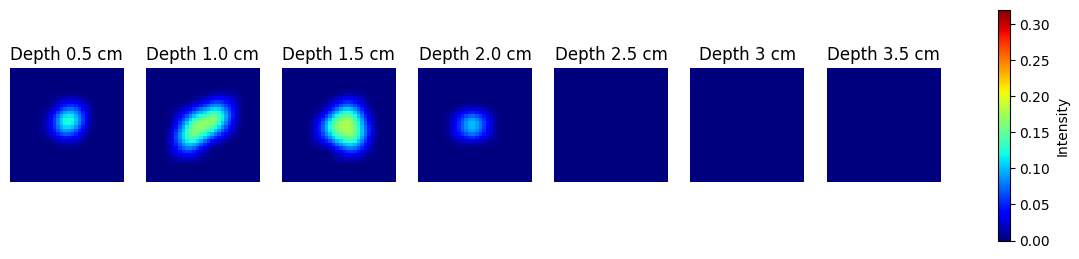

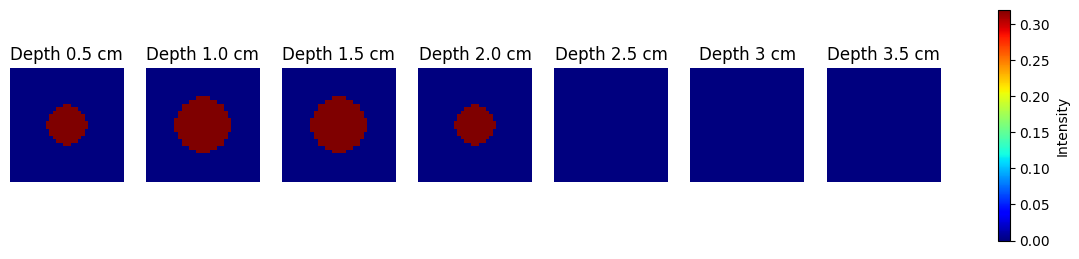

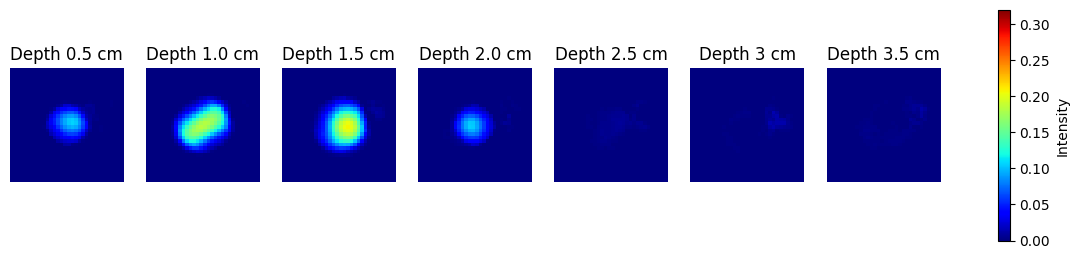

  0%|          | 0/1323 [00:01<?, ?it/s]


NameError: name 'scatter_plot_pert' is not defined

In [43]:
epochs = 500
best_r_score = -1000 
best_phan_score = -10
for epoch in range(epochs): 
    train_fn(inverse_model, forward_model, dis, train_dataloader, opt_inverse, opt_forward, opt_dis, epoch)
    # if epoch%1==0: 
    #     #print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}") 
    #     # print("p2p")
    #     # print("Epoch: ", epoch)
    #     # sample_plot_image(inverse_model)  

    with torch.no_grad():
        metrics = test_fn(inverse_model, forward_model, dis, test_dataloader, opt_inverse, opt_forward, opt_dis, epoch)

        
        if best_r_score < metrics[1]:
                test_fn(inverse_model, forward_model, dis, test_dataloader, opt_inverse, opt_forward, opt_dis, epoch, save_data=True)
                torch.save(inverse_model.state_dict(), 'checkpoints_all_less/model_weights_inverse_operator_best.pth')
                torch.save(forward_model.state_dict(), 'checkpoints_all_less/model_weights_forward_operator_best.pth')
                torch.save(dis.state_dict(), 'checkpoints_all_less/model_weights_discriminator_best.pth')

                best_r_score = metrics[1]
                
        if epoch% 3==0: 
            #print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()}") 
            metrics_phan = test_fn2(inverse_model, phan_dataloader)

            if best_phan_score < metrics_phan[1]:
                best_phan_score = metrics_phan[1]

                torch.save(inverse_model.state_dict(), 'checkpoints_all_less/phan/model_weights_inverse_operator_best.pth')
                torch.save(forward_model.state_dict(), 'checkpoints_all_less/phan/model_weights_forward_operator_best.pth')
                torch.save(dis.state_dict(), 'checkpoints_all_less/phan/model_weights_discriminator_best.pth')

            print("P2P Inverse Model:: ", "Epoch: ", epoch, "Test Mse: ", metrics[0],"Test r_score: ", metrics[1], "Test phan r_score: ", metrics_phan[1])
            
            sample_plot_image(inverse_model)  

100%|██████████| 2353/2353 [01:07<00:00, 34.66it/s, Mean_Square_Error=0.00521]


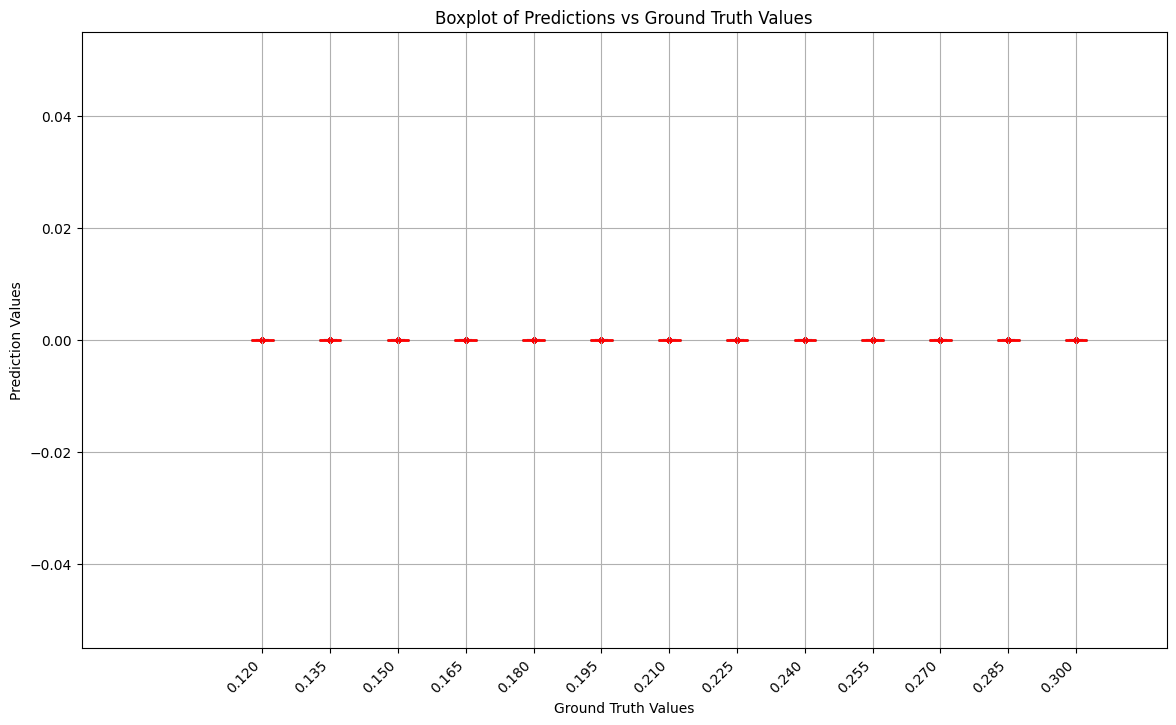

(0.019192085503824168, -14.069457550172142)

In [83]:
test_fn(inverse_model, forward_model, dis, test_dataloader, opt_inverse, opt_forward, opt_dis, epoch, save_data=True)

In [ ]:
print(best_r_score)

# Testing Section

In [ ]:
sample_plot_image_all(inverse_model) 

In [ ]:
torch.save(inverse_model.state_dict(), 'checkpoints/model_weights_inverse_operator.pth')
torch.save(forward_model.state_dict(), 'checkpoints/model_weights_forward_operator.pth')
torch.save(dis.state_dict(), 'checkpoints/model_weights_discriminator.pth')

In [ ]:
inverse_model = Inverse_Operator()  # Initialize the model
inverse_model.load_state_dict(torch.load('checkpoints/experiment1/model_weights_inverse_operator.pth'))  # Load the weights
inverse_model.eval()  # Set the model to evaluation mode
